In [1]:
%pylab inline
gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

# Install Torch

Follow the instructions **appropriate for your system**
https://pytorch.org/get-started/locally/ 

On _your laptops_ which probably DO NOT have CUDA
```bash
conda install -y pytorch-cpu torchvision-cpu -c pytorch
```

**The next example is for a GPU system, do NOT do both(!)**

On _my_ system (GTX1080 GPU, NVIDIA Cuda v9.0)
```bash
conda install -y pytorch torchvision -c pytorch
```


**Restart the notbook** so that the python interpreter can process some of the changes made during installation of torchvision. 

In [2]:
import torch

In [3]:
import torchvision

# An Example

In [4]:
from torchvision.datasets import MNIST

In [5]:
training_data = MNIST('./mndist', train=True,  download=True)

In [6]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mndist
    Transforms (if any): None
    Target Transforms (if any): None

In [7]:
training_data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F28AE0AF208>, tensor(5))

In [8]:
im, target = training_data[0]

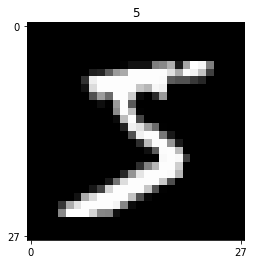

In [9]:
imshow(im);
title(int(target));
xticks([0, im.size[1]-1]);
yticks([0, im.size[0]-1]);

In [10]:
from torchvision import transforms

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [12]:
training_data = MNIST('./mndist', train=True,  download=True, transform=transform)

In [16]:
data, target = training_data[0]
print(type(data))

<class 'torch.Tensor'>


In [14]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=2)

In [17]:
!nvidia-smi

Tue Oct  2 15:57:18 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.77                 Driver Version: 390.77                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   28C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   24C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [18]:
train_iter = iter(train_loader)
images, targets = train_iter.next()

In [19]:
def show_batch(images, targets):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if targets is not None:
            xlabel(str(targets[i].numpy()))

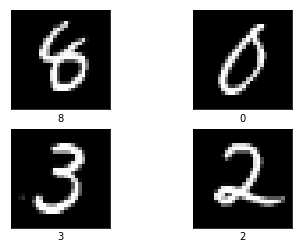

In [20]:
show_batch(images, targets)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
x = images
x.shape

torch.Size([4, 1, 28, 28])

In [24]:
x = x.reshape(x.shape[0], -1)
x.shape

torch.Size([4, 784])

In [25]:
fc = nn.Linear(784, 10)

In [26]:
W, b = fc.parameters()
W.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [27]:
a = fc(x)
a.shape

torch.Size([4, 10])

In [28]:
y = a.argmax(1)
y.shape

torch.Size([4])

In [29]:
y

tensor([8, 5, 4, 3])

In [30]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()))
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))


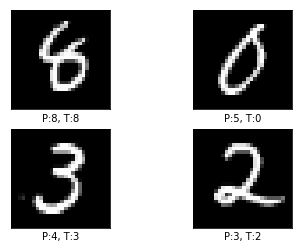

In [31]:
show_batch(images, targets, y)

In [32]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        a = self.fc(x)
        return a  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [33]:
import torch.optim as optim

net = MyNet()

In [35]:
net(x).argmax(1)

tensor([3, 8, 1, 2])

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Will discuss lr and momentum later

While the next cell is running, open up a terminal and type `nvidia-smi` to make sure you are using 100% of your GPU. This is not so important on such a small dataset / model, but for larger problems the (linear) time sivings add up. 

In [37]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.761
[1,  4000] loss: 0.449
[1,  6000] loss: 0.413
[1,  8000] loss: 0.374
[1, 10000] loss: 0.356
[1, 12000] loss: 0.366
[1, 14000] loss: 0.339
[2,  2000] loss: 0.331
[2,  4000] loss: 0.335
[2,  6000] loss: 0.332
[2,  8000] loss: 0.303
[2, 10000] loss: 0.313
[2, 12000] loss: 0.308
[2, 14000] loss: 0.313
Finished Training


In [38]:
y = net(images).argmax(1)

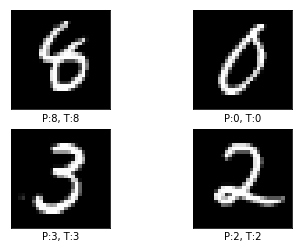

In [39]:
show_batch(images, targets, y)

**ALERT: This was ALL on TRAINING data -- we NEED TEST!!!***

In [40]:
test_data = MNIST('./mndist', train=False,  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=2)

In [41]:
with torch.no_grad():
    cm = np.zeros((10,10), dtype=np.int64)
    for x, y in iter(test_loader):
        p = net(x).argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

In [42]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = arange(10), columns = arange(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,960,0,10,3,1,11,12,4,8,12
1,0,1108,10,1,2,4,3,12,11,7
2,2,2,905,22,4,4,3,22,8,3
3,1,2,17,904,1,28,2,7,18,9
4,0,0,15,0,921,9,10,7,9,51
5,3,3,1,34,0,772,9,0,22,5
6,11,4,15,3,13,17,917,0,13,0
7,1,1,13,14,2,6,1,947,14,27
8,2,15,42,23,10,34,1,3,864,7
9,0,0,4,6,28,7,0,26,7,888


Install $\texttt{seaborn}$ to plot confusion matrices (and many other things) easily.   

In [43]:
import seaborn as sn

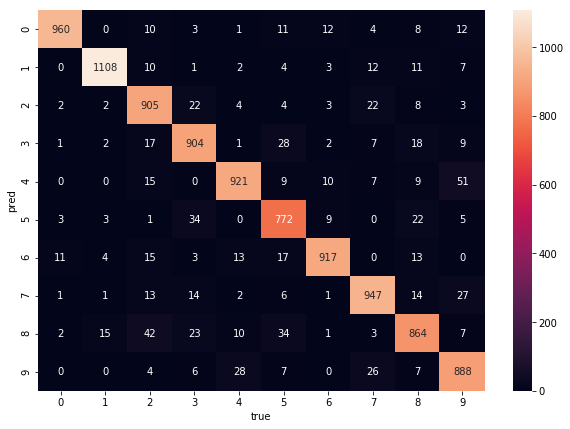

In [44]:
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=True);
ylabel('pred')
xlabel('true');

In [ ]:
acc = np.trace(cm)/ np.sum(cm)
acc

In [ ]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [ ]:
report_from_cm(cm, range(10))

# Lab Activity


Modify the training code as follows:
1. (Optional) Add a `torchvision.transforms.Resize` to the transforms to reduce the size of each image (e.g. to 8x8) so that training is fast on your computer.   
1. Keep track of the loss after each checkpoint so that you can plot it when training completes. 
2. At each checkpoint, compute the loss on the evaluation data and save it to a different list so that you can plot bothe the training _and_ the test loss when training completes. 
3. If necessary, increase the number of epochs until you can see that you overfit the data. 
4. Submit **only** a printout of the plot of training vs test loss, and the code for the training loop. 